In [1]:
pip install scikit-learn


In [4]:
pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.3 MB/s eta 0:00:00


In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Load the Cora dataset
dataset = Planetoid(root='data/Cora', name='Cora', split='public')

Processing...
Done!


In [7]:
# Define a simple Graph Convolutional Network (GCN) model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [8]:
# Initialize the model, optimizer, and criterion
model = GCN(in_channels=dataset.num_features, hidden_channels=64, out_channels=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

In [9]:
# Prepare data for training and testing
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset, batch_size=64, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [10]:
# Training and testing functions
def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [11]:
def test():
    model.eval()
    y_true, y_pred = [], []
    for data in test_loader:
        with torch.no_grad():
            out = model(data.x, data.edge_index)
        y_true.append(data.y[data.test_mask].numpy())
        y_pred.append(out[data.test_mask].argmax(dim=1).numpy())
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    acc = accuracy_score(y_true, y_pred)
    return acc

In [12]:
# Visualize the training loss over epochs
def plot_training_loss(losses):
    plt.plot(losses, label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1, Train Loss: 1.7168, Test Accuracy: 0.7280
Epoch 2, Train Loss: 1.4633, Test Accuracy: 0.7560
Epoch 3, Train Loss: 1.1580, Test Accuracy: 0.7660
Epoch 4, Train Loss: 0.8779, Test Accuracy: 0.7900
Epoch 5, Train Loss: 0.6892, Test Accuracy: 0.8050
Epoch 6, Train Loss: 0.5302, Test Accuracy: 0.8030
Epoch 7, Train Loss: 0.3635, Test Accuracy: 0.8040
Epoch 8, Train Loss: 0.2688, Test Accuracy: 0.8110
Epoch 9, Train Loss: 0.2226, Test Accuracy: 0.8080
Epoch 10, Train Loss: 0.1591, Test Accuracy: 0.8050
Epoch 11, Train Loss: 0.1156, Test Accuracy: 0.8000
Epoch 12, Train Loss: 0.0838, Test Accuracy: 0.7920
Epoch 13, Train Loss: 0.0740, Test Accuracy: 0.7890
Epoch 14, Train Loss: 0.0421, Test Accuracy: 0.7900
Epoch 15, Train Loss: 0.0437, Test Accuracy: 0.7880
Epoch 16, Train Loss: 0.0317, Test Accuracy: 0.7840
Epoch 17, Train Loss: 0.0218, Test Accuracy: 0.7840
Epoch 18, Train Loss: 0.0196, Test Accuracy: 0.7830
Epoch 19, Train Loss: 0.0149, Test Accuracy: 0.7860
Epoch 20, Train Loss:

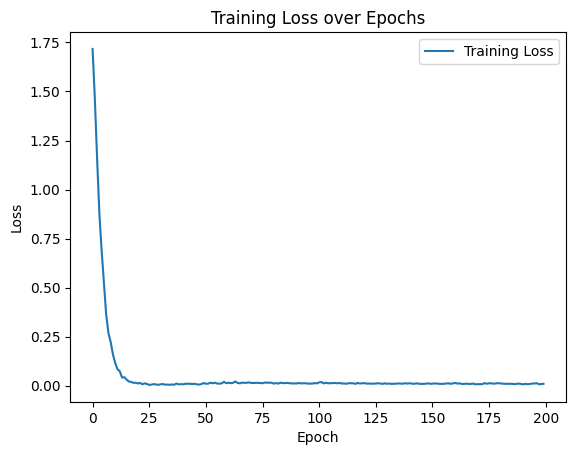

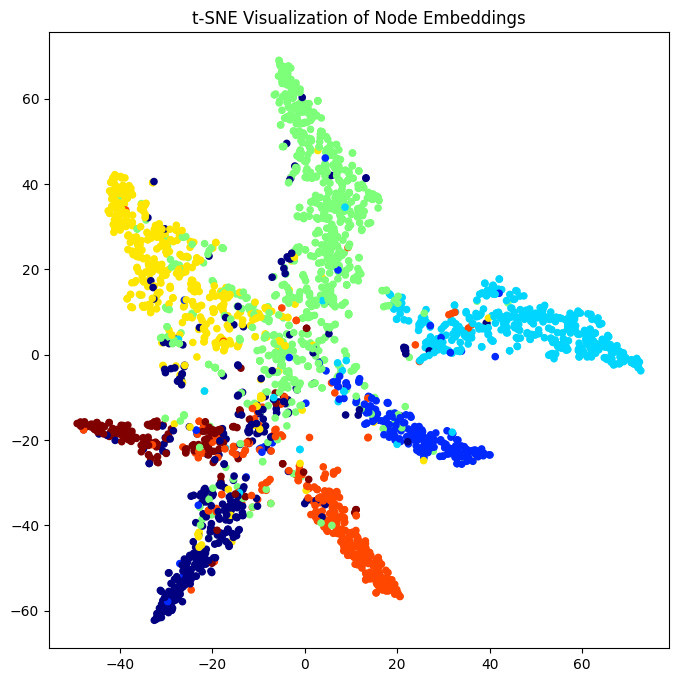

In [15]:
from sklearn.metrics import accuracy_score

# Visualize the t-SNE plot of node embeddings
def visualize_tsne(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index).numpy()
    node_embeddings = TSNE(n_components=2).fit_transform(out)

    # Plot t-SNE
    plt.figure(figsize=(8, 8))
    plt.scatter(node_embeddings[:, 0], node_embeddings[:, 1], c=data.y.numpy(), cmap='jet', s=20)
    plt.title('t-SNE Visualization of Node Embeddings')
    plt.show()

# Training loop with visualization
train_losses = []
for epoch in range(1, 201):
    train_loss = train(epoch)
    test_acc = test()
    train_losses.append(train_loss)
    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Plot the training loss
plot_training_loss(train_losses)

# Visualize the t-SNE plot
visualize_tsne(model, dataset[0])
